# BBox-Generation
---
Segmentation threshold: 0.95

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path: sys.path.append("..")

In [2]:
from concurrent.futures import ThreadPoolExecutor
import sys,os,json, warnings
import warnings
import pandas as pd
import seaborn as sns

import numpy as np
import torchvision,torchcam,torch

import matplotlib.pyplot as plt
import nibabel as nib
import itertools

from multiprocessing import Pool
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
from easydict import EasyDict as edict
from IPython.display import clear_output,display
from ipywidgets import IntSlider, Output

import contextlib

from src.files import preprocess
from src.files.preprocess import tensor2numpy, image2axial,mask_threshold, preprocess_image, normalize,to_grid
from src.files.file import create_directory
from src.types.string import split_custom_filename
from src.display.plot import imshow
from src.display import plot
from src.display.cmap import parula_map
from src.utils.decorator import HiddenPrints
from src.types.df import column_to_tuple, column_to_np
from src.agent import Agent,ThreadSafeReloadedModel
from src.cam import CAM
from src.roi import roi_align
from src import segmentation

## Define variables for segmentation

In [110]:
# Config
cfg = edict()

# Globals
cfg.PRIMARY_CAM_NAME = torchcam.cams.GradCAMpp
cfg.SMOOTHGRADCAMPP_KWARGS = {"std":0.01}
cfg.NUM_WORKERS = 4
cfg.CLR = "\x1B[0K"
cfg.LOGDIR = "../logs"
cfg.CSV_DIR = f"{cfg.LOGDIR}/threshold/segment"
cfg.FIG_DIR = f"{cfg.LOGDIR}/figures"
cfg.RUNDATE = round(datetime.now().timestamp())
cfg.FILENAME_AD = '../data/SPM_categorised/ADNI1/AD/iwADNI_003_S_1257_PT_ADNI_br_raw_20070927124534984_1_S40125_I75578.nii'
cfg.FILENAME_MCI = '../data/SPM_categorised/ADNI1/MCI/iwADNI_003_S_1057_PT_PET_ADNI_br_raw_20100203143109531_74_S79703_I165739.nii'
cfg.FILENAME_CN = '../data/SPM_categorised/ADNI1/CN/iwADNI_005_S_0223_PET_30_min_3D_FDG_-_Iter_Brain_Mode_br_raw_20090401113543048_1_S65364_I140266.nii'
cfg.CHECKPOINT_PATH = "/var/metrics/codetests/logs/tb/final2/resnet18_brew2/20210620181026/version_5/checkpoints/epoch=83-step=2603.ckpt"

# Segmentation
cfg.SEGMENT_THRESHOLD_BOUNDARY = [0.5,1.0]
cfg.SEGMENT_THRESHOLD_STEP = 0.05
cfg.SEGMENT_THRESHOLD = 0.95
cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION = 4
cfg.SEGMENT_OBSERVE_CLASSES = [0,1,2]

# BBOX
cfg.BBOX_CALCULATE = True
cfg.BBOX_CSV_FILENAME = f'{cfg.LOGDIR}/bbox/resnet18_brew2/bbox_1623296141.csv'
cfg.BBOX_THRESHOLD_AREA = 10
cfg.BBOX_THRESHOLD = 0.95
cfg.BBOX_ITERATIONS = 10
cfg.BBOX_OBSERVE_CLASSES = [0,1,2]
cfg.BBOX_LOGDIR = f"{cfg.LOGDIR}/bbox"


# NMS
cfg.NMS_THRESHOLD_BOUNDARY = [0.0,1.0]
cfg.NMS_THRESHOLD_STEP = 0.05
cfg.NMS_MIN_AREA = 0.0

cfg.NMS_THRESHOLD = 0.05
cfg.NMS_THRESHOLD_AD = 0.0
cfg.NMS_THRESHOLD_MCI = 0.0
cfg.NMS_THRESHOLD_CN = 0.0

# ROIAlign
cfg.ROIALIGN_SHAPE = (23,17,20)

# Load trainer and setup CAM extractor
cfg.CAM_EXTRACTOR = ThreadSafeReloadedModel(cfg.CHECKPOINT_PATH, cam_type=torchcam.cams.GradCAMpp)

Global seed set to 420


In [52]:
# Example image to use 
def load_image_from_filename(filename:str) -> dict: 
    class_label = split_custom_filename(filename,'/')[4]
    test_image = image2axial(nib.load(filename).get_fdata())
    test_image[test_image <= 0]=0
    test_image = preprocess_image(test_image)
    return {class_label:test_image}

TEST_IMAGES = {**load_image_from_filename(cfg.FILENAME_AD),**load_image_from_filename(cfg.FILENAME_MCI), **load_image_from_filename(cfg.FILENAME_CN)}

In [5]:
cfg.CAM_EXTRACTOR.trainer.print_info()

INFO:src.agent:
Checkpoint: /var/metrics/codetests/logs/tb/final2/resnet18_brew2/20210620181026/version_5/checkpoints/epoch=83-step=2603.ckpt
Seed: 420



***Defined dataloader:***
Data directory: data/SPM_categorised/ADNI1/
Dataset sizes - Training: 245 Validation: 28 Test: 31
Augmentation: Enabled
KFold: Enabled - Fold: 1/10


# Segmentation and boundary boxes

## Segmentation

Example of segment after CAM

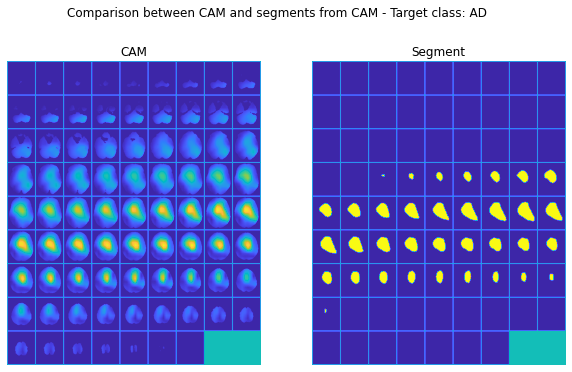

In [6]:
inner = segmentation.Feature_extraction(cfg.CAM_EXTRACTOR, upper_bound=cfg.SEGMENT_THRESHOLD, n_average=cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION)
tmp_segmented = inner.extract(torch.from_numpy(TEST_IMAGES['AD']),1)

fig, axes = plt.subplots(1,2,figsize=(10,6))

axes[0].imshow(to_grid(tmp_segmented[1],max_num_slices=None, nrow=9), cmap=parula_map)
axes[0].set_title("CAM")
axes[0].axis('off')
im = axes[1].imshow(to_grid(tmp_segmented[0],max_num_slices=None, nrow=9), cmap=parula_map)
axes[1].set_title("Segment")
axes[1].axis('off')
fig.suptitle("Comparison between CAM and segments from CAM - Target class: AD")
plt.show()

Example output from the feature extraction of bboxes

In [7]:
inner = segmentation.Feature_extraction(cfg.CAM_EXTRACTOR, upper_bound=cfg.SEGMENT_THRESHOLD)
features = inner.features(1,"Something", torch.from_numpy(TEST_IMAGES["AD"]), 0,1)
features

{'image': 'Something',
 'patient_class': 0,
 'observe_class': 1,
 'probability_class': 2,
 'bbox_area': [102025],
 'mean_intensity': [164.94958597984768],
 'bbox': [(18, 16, 71, 71, 29, 64)],
 'upper_bound': 124.0,
 'use_quantile_bounds': True,
 'score': array([0.47478175])}

In [8]:
inner = segmentation.Feature_extraction(cfg.CAM_EXTRACTOR, upper_bound=cfg.SEGMENT_THRESHOLD)
features = inner.features(1,"Something", torch.from_numpy(TEST_IMAGES["MCI"]), 0,1)
features

{'image': 'Something',
 'patient_class': 0,
 'observe_class': 1,
 'probability_class': 1,
 'bbox_area': [93280],
 'mean_intensity': [170.42133297373832],
 'bbox': [(19, 21, 63, 74, 22, 62)],
 'upper_bound': 135.0,
 'use_quantile_bounds': True,
 'score': array([0.51098924])}

## Evaluate: Nbr. of unique segments 
Calculate how many unique segments are created based on different thresholds, Running over the validation set and average over N sample from the CAM.

In [9]:
def evalaute_average_threshold_scores(extractor, idx, tmp_image, patient_class, target_class):
    return extractor.features(1,"Something", tmp_image, patient_class,target_class)

def generate_features_by_threshold(cam_extractor):

    threshold_data = []
    data = []
    
    LIST_THRESHOLDS = [round(th,2) for th in [*np.arange(*cfg.SEGMENT_THRESHOLD_BOUNDARY, cfg.SEGMENT_THRESHOLD_STEP), cfg.SEGMENT_THRESHOLD_BOUNDARY[-1]]]
    total_iterations = len(LIST_THRESHOLDS)*cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION
    
    # Setup widget for Jupyter
    printer_out = Output()
    display(printer_out)
    for threshold_index, threshold in enumerate(LIST_THRESHOLDS,start=1):
        # Define our data
        IMAGE_FILES = cam_extractor.get_validation_images(observe_classes=cfg.SEGMENT_OBSERVE_CLASSES)

        # Only print to the widget
        with printer_out:
            clear_output()
            print(f'Threshold: {threshold_index}/{len(LIST_THRESHOLDS)} ({threshold}{cfg.CLR})\n{cfg.CLR}' \
            f'Num average: {cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION}\n{cfg.CLR}'
            f'Total: {(cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION*(threshold_index))}/{total_iterations}{cfg.CLR}')#\n)


        #with contextlib.redirect_stdout(None):
        with ThreadPoolExecutor(max_workers=cfg.NUM_WORKERS) as executor:

            extractor = segmentation.Feature_extraction(cam_extractor, upper_bound=threshold, n_average=cfg.SEGMENT_REPEAT_THRESHOLD_ITERATION)
            results = list(executor.map(lambda x: evalaute_average_threshold_scores(extractor, *x), IMAGE_FILES))
        threshold_data.extend([threshold]*len(results))
        data.extend(results)

        threshold_data.extend([threshold]*len(results))
        data.extend(results)

            
            
    threshold_df = pd.DataFrame(data)
    threshold_df["Threshold"] = threshold_data
    threshold_df = threshold_df[['bbox_area', 'mean_intensity','observe_class', 'score', 'Threshold']].apply(pd.Series.explode)

    # Tweak columns names
    threshold_df.rename(columns = {'bbox_area' : 'Area', 'mean_intensity':'Intensity', "observe_class":"Disorder", "score":"Score"}, inplace = True)
    threshold_df.replace({"Disorder": {0: "CN", 1: "MCI", 2:"AD"}}, inplace=True)
    threshold_df.reset_index(inplace = True)
    threshold_df.rename(columns = {'index' : 'Sample'}, inplace = True)

    # Change type
    my_cols = set(threshold_df.columns)
    my_cols.remove("Disorder")
    threshold_df[list(my_cols)] = threshold_df[list(my_cols)].apply(pd.to_numeric)

    # Process data
    threshold_df.dropna(0,inplace=True)
    return threshold_df

In [10]:
# Add data
threshold_df = generate_features_by_threshold(cfg.CAM_EXTRACTOR)

threshold_df.to_csv(f"{cfg.CSV_DIR}/{round(datetime.now().timestamp())}")

Output()

/home/stud/f/fremar16/miniconda3/envs/Master-thesis/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## Visualise: Relation between features
Observe relation between features before deciding which threshold to use

In [11]:
def visualise_threshold_features(df, save_dir=None, title=None):
    fig, axes = plt.subplots(5, 2, figsize=(18,18))
    
    flatten_axes = axes.flatten()

    ax = sns.barplot(x="Threshold",y=df.index,hue="Disorder",data=df, ax=flatten_axes[0])
    ax.set_title("Analysis of threshold and number of segments")

    ax = sns.barplot(x="Threshold",y="Area",hue="Disorder",data=df, ax=flatten_axes[1])
    ax.set_title("Analysis of threshold and pixel area")

    ax = sns.barplot(x="Threshold",y="Intensity",hue="Disorder",data=df, ax=flatten_axes[2])
    ax.set_title("Analysis of threshold and Mean Intensity")


    ax = sns.barplot(x="Threshold",y="Score",hue="Disorder",data=df, ax=flatten_axes[3])
    ax.set_title("Analysis of threshold and Score")


    ax = sns.scatterplot(y="Area",x="Score",hue="Threshold",data=df, ax=flatten_axes[4], palette="colorblind")
    ax.set_title("Analysis of threshold; Area vs Score")


    ax = sns.scatterplot(y="Intensity",x="Score",hue="Threshold",data=df, ax=flatten_axes[5], palette="colorblind")
    ax.set_title("Analysis of threshold; Intensity vs Score")


    ax = sns.scatterplot(y="Area",x="Intensity",hue="Threshold",data=df, ax=flatten_axes[6], palette="colorblind")
    ax.set_title("Analysis of threshold; Area vs Intensity")

    ax = sns.boxplot(y="Score", x="Threshold",data=df, ax=flatten_axes[7])
    ax.set_title("Analysis of threshold; Score vs Threshold")

    relation_df = df.copy()
    relation_df["Relation"] =df["Area"]/df["Intensity"]

    ax = sns.scatterplot(y="Relation", x="Sample", hue="Threshold",data=relation_df, palette="colorblind",ax=flatten_axes[8])
    ax.set_title("Relation between Area and Intensity for different thresholds")
    ax.set_ylabel("Area/Intensity")

    fig.suptitle(title)
    plt.tight_layout()
    if save_dir: plt.savefig(save_dir)
    plt.show()

<Figure size 2304x720 with 0 Axes>

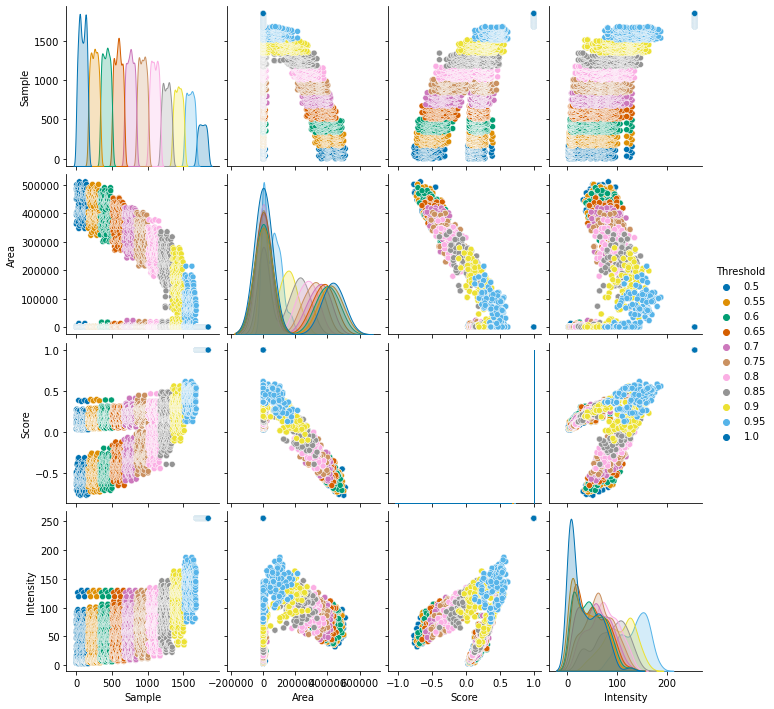

In [12]:
fig = plt.figure(figsize=(32,10))
plt.suptitle("Pairplot of segmented features")
my_cols = set(threshold_df.columns)
my_cols.remove("Disorder")
ax = sns.pairplot(threshold_df[my_cols], hue="Threshold", palette="colorblind", kind="scatter")

#plt.tight_layout()
plt.savefig(f"{cfg.FIG_DIR}/feature_relations/segment_thresholds/{cfg.RUNDATE}")
plt.show()

## Evaluate Grad-CAM++ vs Smooth Grad-CAM++

Compare Grad-CAM++ and Smooth Grad-CAM++

In [13]:
print("Grad-CAM++")
threshold_gradcam_df = generate_features_by_threshold(ThreadSafeReloadedModel(cfg.CHECKPOINT_PATH, cam_type=torchcam.cams.GradCAMpp))

Global seed set to 420


Grad-CAM++


Output()

In [14]:
print("Smooth Grad-CAM++")
threshold_smoothcam_df = generate_features_by_threshold(ThreadSafeReloadedModel(cfg.CHECKPOINT_PATH, cam_type=torchcam.cams.SmoothGradCAMpp, cam_kwargs=cfg.SMOOTHGRADCAMPP_KWARGS))

Global seed set to 420


Smooth Grad-CAM++


Output()

In [15]:
threshold_gradcam_df.to_csv(f"{cfg.LOGDIR}/threshold/gradcam/{round(datetime.now().timestamp())}")
threshold_smoothcam_df.to_csv(f"{cfg.LOGDIR}/threshold/smoothgradcam/{round(datetime.now().timestamp())}")

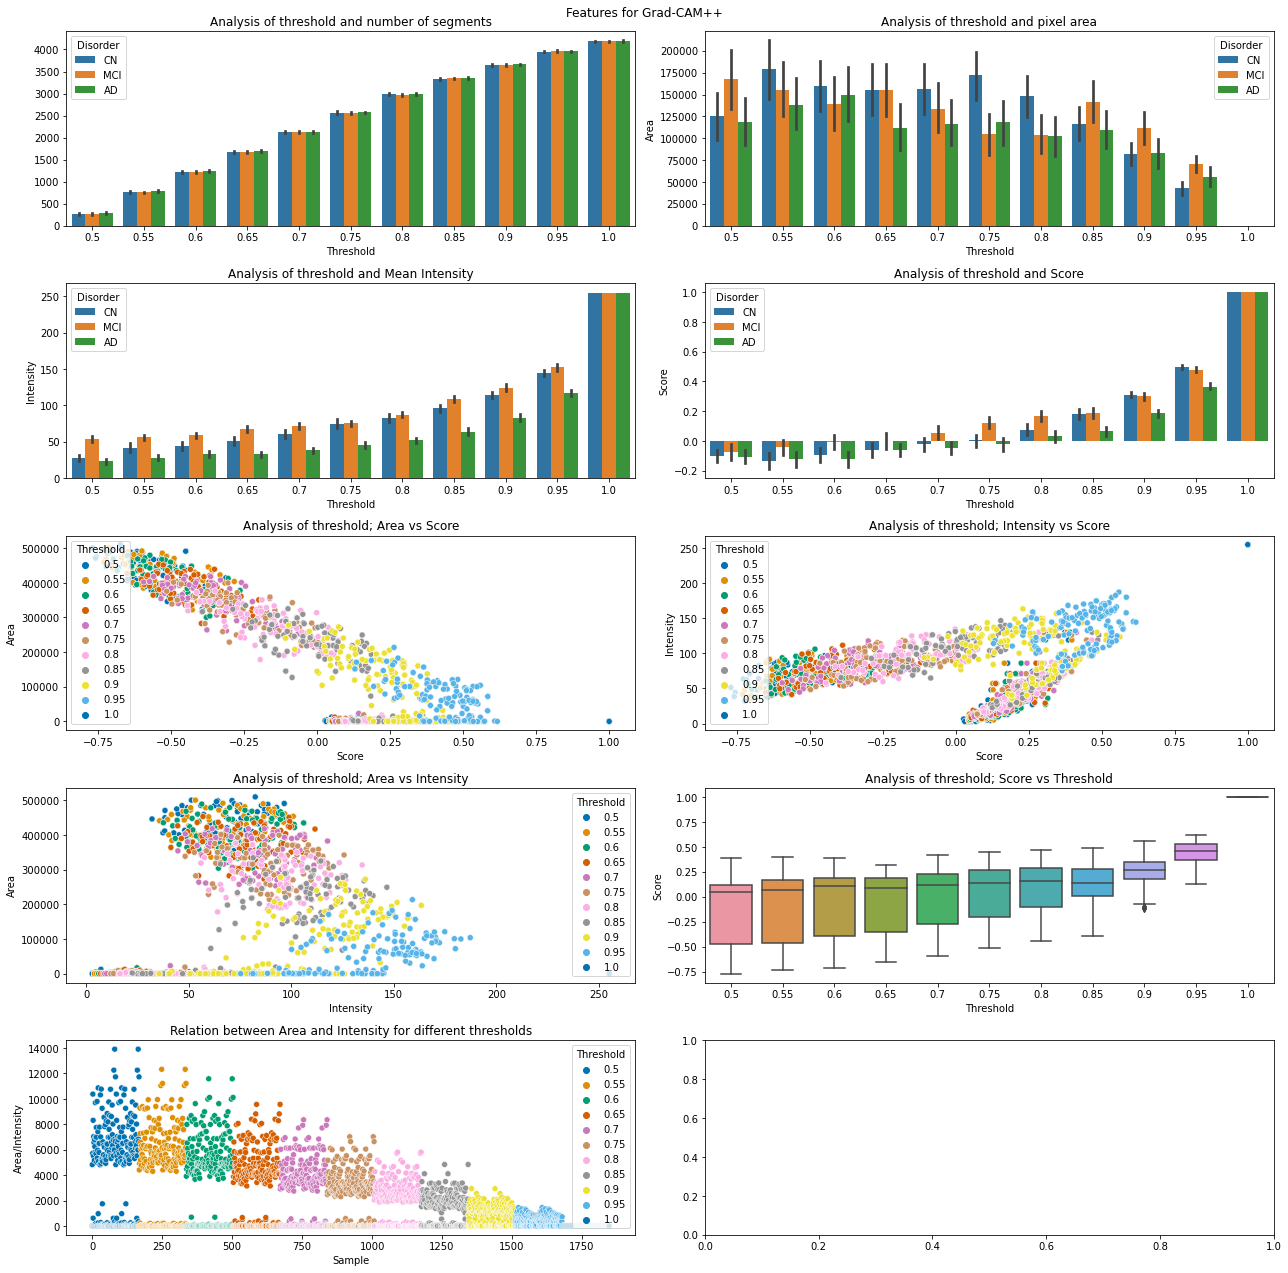

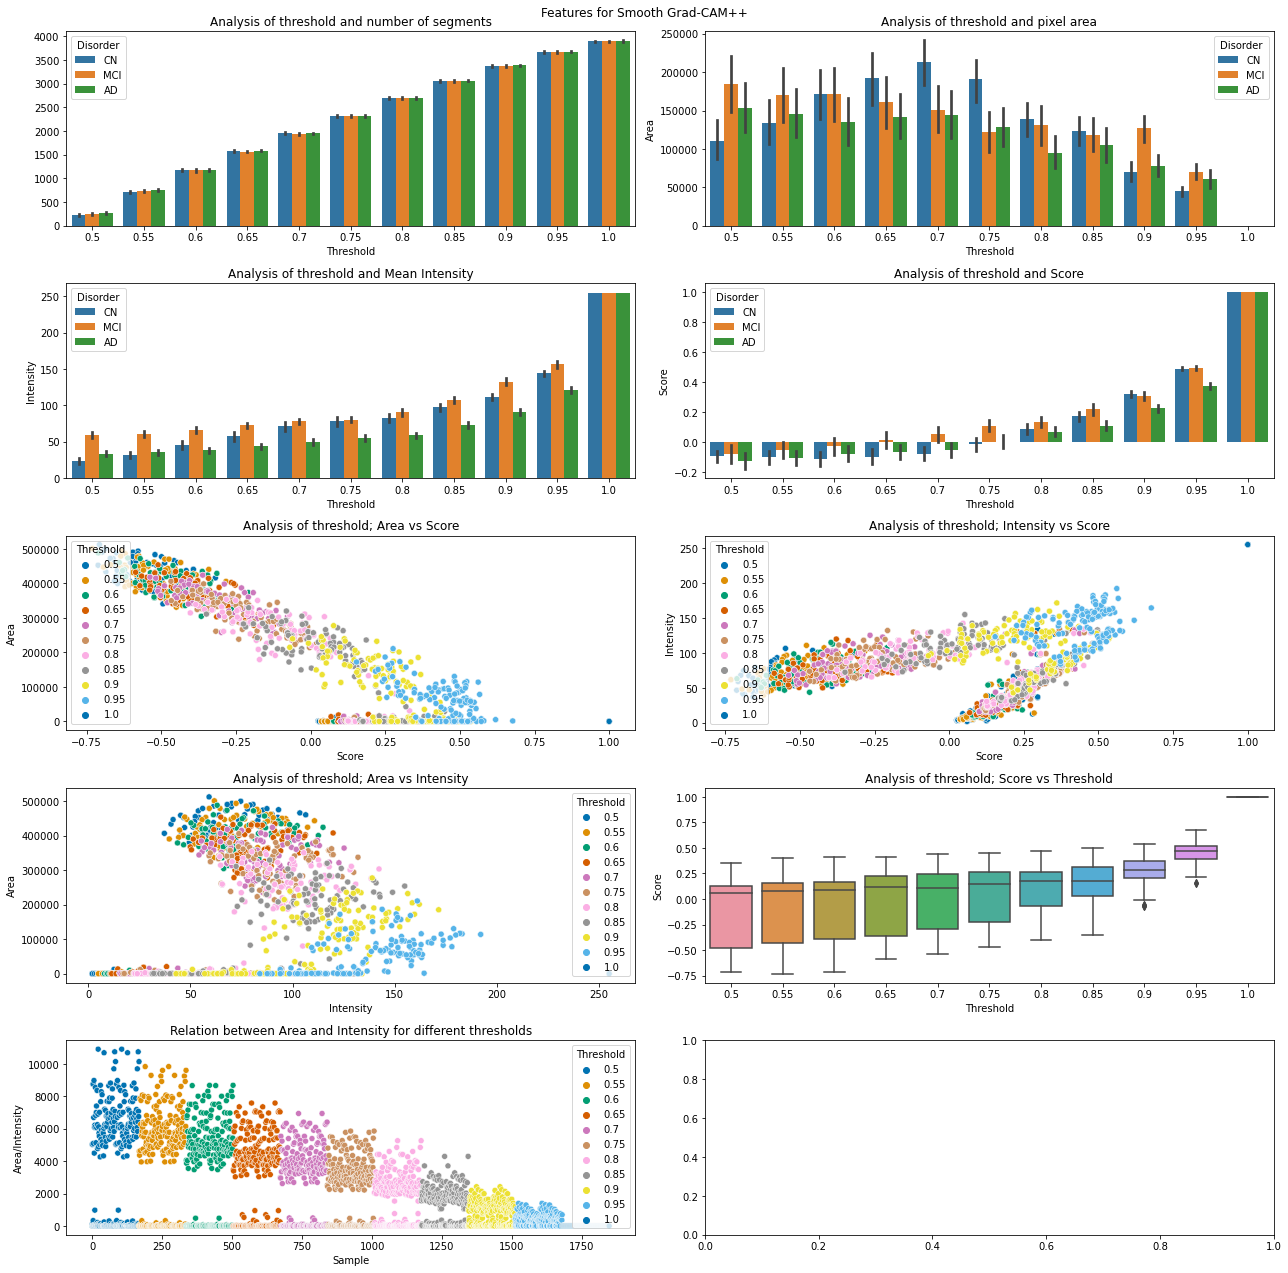

In [16]:
#print("Grad-CAM++")
visualise_threshold_features(threshold_gradcam_df, save_dir=f"{cfg.FIG_DIR}/feature_relations/gradcampp/{cfg.RUNDATE}", title="Features for Grad-CAM++")

#print("Smooth Grad-CAM++")
visualise_threshold_features(threshold_smoothcam_df, save_dir=f"{cfg.FIG_DIR}/feature_relations/smoothgradcampp/{cfg.RUNDATE}", title="Features for Smooth Grad-CAM++")

# BBox Generation

## Generate bbox features
Collect BBoxes from file or analyse. 
Save the bboxes to local storage.


In [111]:
if cfg.BBOX_CALCULATE:
    bboxes_dict = []
    
    printer_out = Output()
    display(printer_out)
    extraction_method = segmentation.Feature_extraction(cfg.CAM_EXTRACTOR, upper_bound=cfg.BBOX_THRESHOLD, n_average=cfg.BBOX_ITERATIONS)
    bboxes= []   
    with printer_out:
        clear_output()
        print(f"Num Average: {cfg.BBOX_ITERATIONS}\n{cfg.CLR}"
              f"Total: {cfg.BBOX_ITERATIONS} /{cfg.BBOX_ITERATIONS}", 
              end="")


    FILESET = cfg.CAM_EXTRACTOR.get_validation_images()
    IMAGE_FILES = cfg.CAM_EXTRACTOR.get_validation_images(observe_classes=cfg.BBOX_OBSERVE_CLASSES)
    with contextlib.redirect_stdout(None):
        with ThreadPoolExecutor(max_workers=10) as executor:
            results = executor.map(lambda p: extraction_method.features(*p) ,((idx, FILESET.data[idx].rsplit("/",1)[1], image, patient_class, observe_class) for idx, image, patient_class, observe_class in IMAGE_FILES))
            bboxes.extend(list(results))

    bboxes_dict.extend(bboxes)
        
    # Convert data to dataframe
    bboxes_df = pd.DataFrame(bboxes_dict)
    bboxes_df.rename(columns = {'index' : 'image', 'bbox':'bbox'}, inplace = True)
    bboxes_df['bbox_count'] = bboxes_df['bbox'].str.len()
    bboxes_df = bboxes_df[bboxes_df['bbox_count']>0]
    bboxes_df = bboxes_df.apply(pd.Series.explode)
    bboxes_df['bbox'] = bboxes_df['bbox'].apply(lambda row: list(row))

    bboxes_df.reset_index(inplace = True)
    bboxes_df.rename(columns = {'index' : 'Image_class'}, inplace = True)
    bboxes_df.head(20)

    # Sort data
    bboxes_df.sort_values('score',ascending=False,inplace=True)

    # Save to logs
    now = round(datetime.now().timestamp())
    checkpoint_names = cfg.CAM_EXTRACTOR.trainer._config["checkpoint_path"].rsplit("/",6)[1:-2]


    name = f"""{cfg.LOGDIR}/bbox/{checkpoint_names[1]}/bbox_{now}.csv"""#f"../logs/bbox/{model._hparams['arch']['name']}/bbox_{now}.csv
    os.makedirs(f"""{cfg.LOGDIR}/bbox/{checkpoint_names[1]}""", exist_ok=True)
    bboxes_df.to_csv(name,index=False,header=True)

    entry = {"base":checkpoint_names[0], "version":checkpoint_names[3],"model_date":checkpoint_names[2], "CAM":str(cfg.PRIMARY_CAM_NAME),"chechpoint":cfg.CAM_EXTRACTOR.trainer._config["checkpoint_path"], "log_dir":name,"threshold": cfg.BBOX_THRESHOLD, "iterations":cfg.BBOX_ITERATIONS}

    # Open file
    with open(f"{cfg.LOGDIR}/bbox/experiments.json", "r") as jsonFile:
        data = json.load(jsonFile)

    if checkpoint_names[1] not in data:
        data.update({checkpoint_names[1]:{}})


    data[checkpoint_names[1]].update({str(now):entry})

    # Close file
    with open(f"{cfg.LOGDIR}/bbox/experiments.json", "w") as jsonFile:
        json.dump(data, jsonFile)

else:
    bboxes_df = pd.read_csv(cfg.BBOX_FILENAME, dtype={'patient_class':int, 'observe_class':int,'probability_class':int,'bbox_count':int})
    bboxes_df['bbox'] = column_to_np(column_to_tuple(bboxes_df['bbox']))


Output()

In [112]:
bboxes_df

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,use_quantile_bounds,score,bbox_count
29,16,iwADNI_033_S_1285_PT_ADNI_STATIC_BRAIN__br_raw...,2,1,1,90,144.428571,"[35, 26, 38, 36, 57, 60]",143.0,True,0.616885,2
13,7,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,1,2,1008,145.204852,"[48, 56, 60, 70, 11, 17]",143.0,True,0.608106,2
81,43,iwADNI_018_S_0155_PT_ADNI_Static_Brain__6x5___...,1,1,2,72160,180.035098,"[30, 39, 74, 79, 11, 52]",146.0,True,0.584312,1
11,6,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,0,2,30600,157.792117,"[49, 36, 74, 72, 26, 60]",132.0,True,0.583682,2
64,33,iwADNI_011_S_0861_PET_30_min_3D_FDG_4i_16s__br...,1,0,1,2,136.0,"[42, 57, 43, 59, 76, 77]",135.0,True,0.573651,5
...,...,...,...,...,...,...,...,...,...,...,...,...
85,47,iwADNI_052_S_1346_PT_ADNI_Brain_PET__Raw_FDG_b...,1,2,1,146757,137.554519,"[17, 12, 70, 83, 14, 53]",100.0,True,0.226515,2
58,32,iwADNI_941_S_1295_PT_ADNI_Brain_PET__Raw_br_ra...,1,2,1,101088,110.337771,"[14, 3, 66, 57, 26, 62]",74.0,True,0.193562,2
71,38,iwADNI_128_S_0225_PET_ADNI_Brain_PET__Raw_br_r...,1,2,1,175854,139.832329,"[16, 4, 69, 83, 13, 55]",104.0,True,0.185422,2
21,11,iwADNI_003_S_1257_PT_ADNI_br_raw_2007092712453...,2,2,2,171000,118.233134,"[15, 5, 72, 80, 19, 59]",83.0,True,0.13449,2


<AxesSubplot:title={'center':'Intensity and area of bboxes'}>

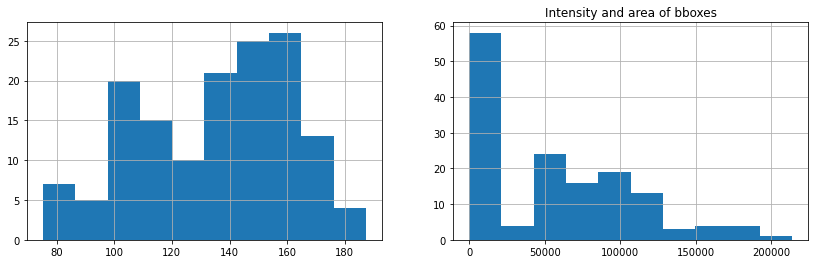

In [113]:
## Analyse: Check distributions for validating clusters
fig, axes = plt.subplots(1, 2, figsize=(14,4))
flatten_axes = axes.flatten()
plt.title("Intensity and area of bboxes")
bboxes_df.mean_intensity.hist(ax=flatten_axes[0]) # x: snitt intensitet, y: Frekvens
bboxes_df.bbox_area.hist(ax=flatten_axes[1]) # x:storlek i pixlar, y: Frekvens

In [114]:
def plot_bbox_category_scatter(bboxes_df, upper_limit=None, lower_limit=None):
    _bboxes_df = bboxes_df.copy()
    if upper_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']<=upper_limit]
    if lower_limit:
        _bboxes_df = _bboxes_df.loc[_bboxes_df['bbox_area']>=lower_limit]
    
    cn_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 0) & (_bboxes_df['patient_class'] == 0) ]
    mci_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 1) & (_bboxes_df['patient_class'] == 1)]
    ad_bboxes = _bboxes_df.loc[(bboxes_df['observe_class'] == 2) & (_bboxes_df['patient_class'] == 2)]

    fig = plt.figure()
    plt.title("Relation between area and intensity")
    plt.xlabel("Intensity")
    plt.ylabel("Area")
    plt.scatter(cn_bboxes.mean_intensity,cn_bboxes.bbox_area,color='blue',label='CN',alpha=0.5)
    plt.scatter(mci_bboxes.mean_intensity,mci_bboxes.bbox_area,color='green',label='MCI',alpha=0.5)
    plt.scatter(ad_bboxes.mean_intensity,ad_bboxes.bbox_area,color='purple',label='AD',alpha=0.5)
    #plt.plot((100,240),(0,400000), color='red')
    plt.legend(loc='upper left')
    plt.show()
    return cn_bboxes,mci_bboxes,ad_bboxes

In [115]:
bboxes_df.loc[(bboxes_df['bbox_area'] > 20000) & (bboxes_df['bbox_area'] < 170000)]

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,use_quantile_bounds,score,bbox_count
81,43,iwADNI_018_S_0155_PT_ADNI_Static_Brain__6x5___...,1,1,2,72160,180.035098,"[30, 39, 74, 79, 11, 52]",146.0,True,0.584312,1
11,6,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,0,2,30600,157.792117,"[49, 36, 74, 72, 26, 60]",132.0,True,0.583682,2
41,22,iwADNI_033_S_0511_PT_ADNI_STATIC_BRAIN__br_raw...,1,1,2,104060,187.270533,"[27, 27, 71, 82, 15, 58]",156.0,True,0.558883,1
12,6,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,0,2,50310,166.207554,"[22, 46, 61, 89, 41, 71]",132.0,True,0.550439,2
84,46,iwADNI_052_S_1346_PT_ADNI_Brain_PET__Raw_FDG_b...,1,1,1,100170,182.705429,"[27, 25, 72, 78, 12, 54]",148.0,True,0.547541,1
...,...,...,...,...,...,...,...,...,...,...,...,...
120,68,iwADNI_094_S_1314_PET_30MIN_3D_FDG_4i_16s__br_...,1,2,0,78960,130.444393,"[10, 3, 70, 50, 33, 61]",79.0,True,0.232184,7
102,59,iwADNI_007_S_0414_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,1,2,1,115920,125.907963,"[14, 3, 70, 72, 27, 57]",89.0,True,0.229959,3
85,47,iwADNI_052_S_1346_PT_ADNI_Brain_PET__Raw_FDG_b...,1,2,1,146757,137.554519,"[17, 12, 70, 83, 14, 53]",100.0,True,0.226515,2
58,32,iwADNI_941_S_1295_PT_ADNI_Brain_PET__Raw_br_ra...,1,2,1,101088,110.337771,"[14, 3, 66, 57, 26, 62]",74.0,True,0.193562,2


## Analyse: Relation between area and intensity

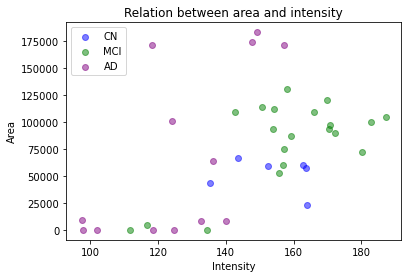

In [116]:
cn_bboxes, mci_bboxes, ad_bboxes = plot_bbox_category_scatter(bboxes_df, lower_limit=cfg.BBOX_THRESHOLD_AREA)

## Analyse: Evaluate threshold

In [117]:
BBOXES = {'CN':cn_bboxes, 'MCI':mci_bboxes, 'AD':ad_bboxes}

In [118]:
def image2area(image):
    return image.shape[0]*image.shape[1]*image.shape[2]

def box2area(box):
    return (box[2]-box[0])*(box[3]-box[1])*(box[5]-box[4])

def box2shape(box):
    return [box[2]-box[0],box[3]-box[1],box[5]-box[4]]

def area_diff(original, new):
    "Calculate how much the image area is reduced. A score of 0 indicates 0% reduction and 1 indicates 100% reduction"
    return (1 - (new/original)) *100

Iterate threshold

In [119]:
data = {"Threshold":[], "Disorder":[], "Frequency": [], "bbox":[]}
TOTAL_ITERATIONS = [round(th,2) for th in [*np.arange(*cfg.NMS_THRESHOLD_BOUNDARY, cfg.NMS_THRESHOLD_STEP), cfg.NMS_THRESHOLD_BOUNDARY[-1]]]

printer_out = Output()
display(printer_out)
    
for threshold_iteration, threshold in enumerate(TOTAL_ITERATIONS, start=1):

    for bbox_iteration, (bbox_name,bbox_items) in enumerate(BBOXES.items(), start=1):
        with printer_out:
            clear_output(wait=True)
            print(
                f"Threshold: {threshold:.2f} ({threshold_iteration}/{len(TOTAL_ITERATIONS)})\n"
                f"Iteration: {bbox_iteration}/{(len(BBOXES.items()))}",
                end="\r"
            )
            results = segmentation.nms_reduction(bbox_items[bbox_items['score']>cfg.NMS_MIN_AREA],th=threshold).int()#.tolist()

        data["Threshold"].append(round(threshold,2))
        data["Frequency"].append(results.shape[0])
        data["Disorder"].append(bbox_name)
        data["bbox"].append(results.tolist())

nms_df = pd.DataFrame.from_dict(data).apply(pd.Series.explode)#(list(data.items()))#.transpose()

Output()

In [120]:
# Calculate area
nms_df["Area"] = nms_df.bbox.apply(lambda x: box2area(x))

In [121]:
nms_df["Reduction"] = nms_df.Area.apply(lambda x: area_diff(image2area(TEST_IMAGES["AD"]), x))#.bbox.apply(lambda x: box2area(x)/image2area(TEST_IMAGE))

In [122]:
nms_df.reset_index(inplace = True)
nms_df.rename(columns = {'index' : 'Segment_idx'}, inplace = True)

In [123]:
nms_bbox_df = pd.concat([nms_df,pd.DataFrame(nms_df.bbox.apply(lambda x: box2shape(x)).to_list(), columns=['bbox_X','bbox_Y', "bbox_Z"])], axis=1)

In [124]:
nms_bbox_df

,Segment_idx,Threshold,Disorder,Frequency,bbox,Area,Reduction,bbox_X,bbox_Y,bbox_Z
0,0,0.0,CN,1,"[33, 39, 74, 80, 24, 58]",57154,90.360182,41,41,34
1,1,0.0,MCI,3,"[30, 39, 74, 79, 11, 52]",72160,87.829211,44,40,41
2,1,0.0,MCI,3,"[18, 27, 28, 40, 34, 37]",390,99.934221,10,13,3
3,1,0.0,MCI,3,"[42, 18, 46, 21, 42, 44]",24,99.995952,4,3,2
4,2,0.0,AD,5,"[54, 52, 61, 62, 58, 61]",210,99.964581,7,10,3
...,...,...,...,...,...,...,...,...,...,...
469,62,1.0,AD,13,"[12, 3, 69, 62, 27, 57]",100890,82.983496,57,59,30
470,62,1.0,AD,13,"[17, 18, 73, 86, 13, 61]",182784,69.170932,56,68,48
471,62,1.0,AD,13,"[17, 6, 71, 85, 16, 56]",170640,71.219187,54,79,40
472,62,1.0,AD,13,"[17, 3, 72, 82, 16, 56]",173800,70.686209,55,79,40


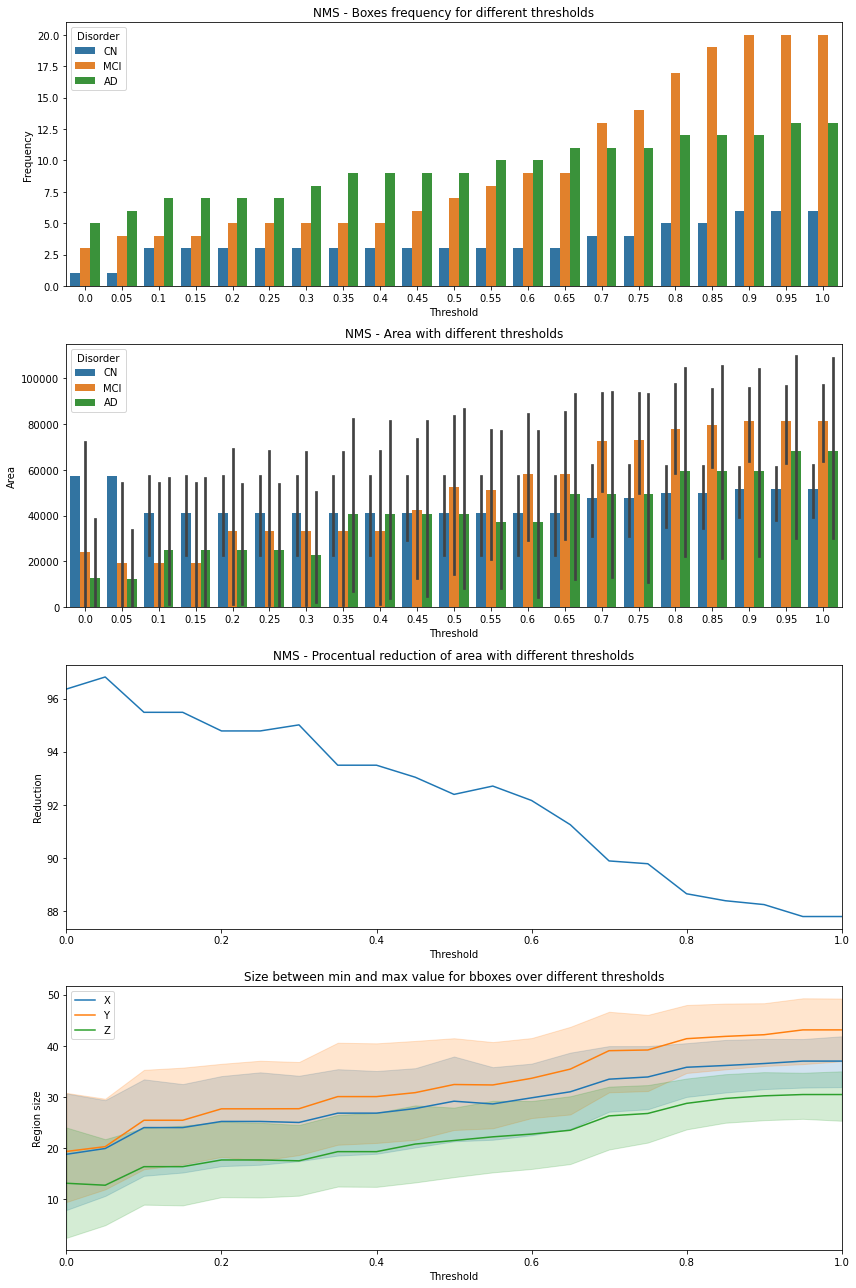

In [125]:
fig, axes = plt.subplots(4,1,figsize=(12,18))
flatten_axes = axes.flatten()
ax = sns.barplot(x="Threshold",y="Frequency", hue='Disorder',data=nms_df, ax=flatten_axes[0])
ax.set_title("NMS - Boxes frequency for different thresholds")


ax = sns.barplot(x="Threshold",y="Area", hue='Disorder',data=nms_df, ax=flatten_axes[1])
ax.set_title("NMS - Area with different thresholds")

ax = sns.lineplot(x="Threshold",y="Reduction",data=nms_df.groupby(["Threshold"])[["Reduction","Threshold"]].mean(), ax=flatten_axes[2])
ax.set_title("NMS - Procentual reduction of area with different thresholds")
ax.set_xlim(left=0, right=1)

ax = sns.lineplot(x="Threshold",y="bbox_X",data=nms_bbox_df, ax=flatten_axes[3])
ax = sns.lineplot(x="Threshold",y="bbox_Y",data=nms_bbox_df, ax=flatten_axes[3])
ax = sns.lineplot(x="Threshold",y="bbox_Z",data=nms_bbox_df, ax=flatten_axes[3])
ax.set_title("Size between min and max value for bboxes over different thresholds")
ax.set_xlim(left=0, right=1)
ax.set_ylabel("Region size")
ax.legend(["X", "Y", "Z"])
plt.tight_layout()
plt.savefig(f"../logs/figures/nms_threshold/{cfg.RUNDATE}")

## Analyse: Plot suggested bounding boxes for each class

In [126]:
ad_interesting = segmentation.nms_reduction(ad_bboxes[ad_bboxes['score']>cfg.NMS_THRESHOLD_AD],th=cfg.NMS_THRESHOLD)
mci_interesting = segmentation.nms_reduction(mci_bboxes[mci_bboxes['score']>cfg.NMS_THRESHOLD_MCI], th=cfg.NMS_THRESHOLD)
cn_interesting = segmentation.nms_reduction(cn_bboxes[cn_bboxes['score']>cfg.NMS_THRESHOLD_CN],th=cfg.NMS_THRESHOLD)

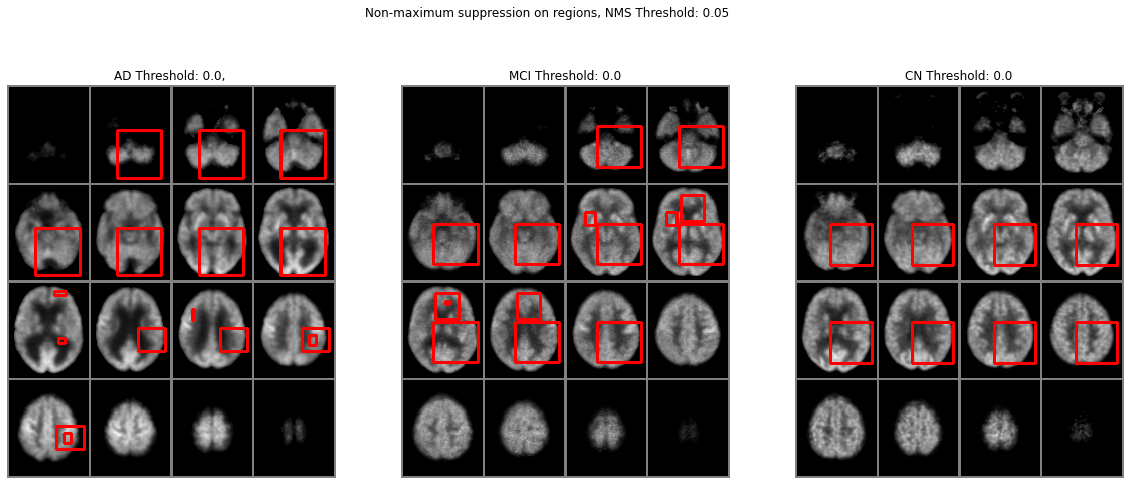

In [127]:
grid_kwgs={'max_num_slices':16, 'nrow':4}

fig = plt.figure(figsize=(20,8))
plt.suptitle(f"Non-maximum suppression on regions, NMS Threshold: {cfg.NMS_THRESHOLD}")

ax1 = plt.subplot(131)
plot.features_regions(ad_interesting.numpy().astype(int),TEST_IMAGES["AD"], grid_kwgs=grid_kwgs)
ax1.set_title(f"AD Threshold: {cfg.NMS_THRESHOLD_AD}")

ax2 = plt.subplot(132)
plot.features_regions(mci_interesting.numpy().astype(int),TEST_IMAGES["MCI"],grid_kwgs=grid_kwgs)
ax2.set_title(f"MCI Threshold: {cfg.NMS_THRESHOLD_MCI}")


ax3 = plt.subplot(133)
plot.features_regions(cn_interesting.numpy().astype(int),TEST_IMAGES["CN"],grid_kwgs=grid_kwgs)
ax3.set_title(f"CN Threshold: {cfg.NMS_THRESHOLD_CN}")


plt.savefig(f"../logs/figures/nms/{cfg.RUNDATE}")

# Improvement of area


In [128]:
image_area = image2area(TEST_IMAGES["AD"])

ad_area = np.array(list(map(box2area, ad_interesting.tolist())))
mci_area = np.array(list(map(box2area, mci_interesting.tolist())))
cn_area = np.array(list(map(box2area, cn_interesting.tolist())))

In [129]:
disorder_area = [
    {"Area":area, "Disorder":disorder, "Diff":area_diff(image_area, area)} for disorder, area in {"AD":ad_area, "MCI":mci_area, "CN":cn_area}.items()
]

area_df = pd.DataFrame(disorder_area).apply(pd.Series.explode)
area_df[["Area", "Diff"]] = area_df[["Area", "Diff"]].astype(float)

print(f"Average reduction of AD region size: {area_df.groupby('Disorder').Diff.mean().AD}")
print(f"Average reduction of MCI region size: {area_df.groupby('Disorder').Diff.mean().MCI}")
print(f"Average reduction of CN region size: {area_df.groupby('Disorder').Diff.mean().CN}")

Average reduction of AD region size: 97.94426781583024
Average reduction of MCI region size: 96.7381239511212
Average reduction of CN region size: 90.36018181971512


## Analyse: Show tables of interesting boxes

In [130]:
def find_interesting_from_df(df_data, interesting_data):
    new_rows = df_data.apply(lambda row: row if list(row.bbox) in interesting_data.int().tolist() else 0, axis=1)
    return new_rows[new_rows.bbox_count != 0]

# Number of total boxes
print(ad_bboxes.shape[0])
print(mci_bboxes.shape[0])
print(cn_bboxes.shape[0])

13
20
6


In [131]:
find_interesting_from_df(ad_bboxes, ad_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,use_quantile_bounds,score,bbox_count
10,5,iwADNI_012_S_0720_PT_ADNIstaticBrain_6x5__br_r...,2,2,2,210,124.839286,"[54, 52, 61, 62, 58, 61]",120.0,True,0.552307,2
16,8,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,2,2,30,118.533333,"[49, 55, 55, 60, 43, 44]",118.0,True,0.531072,3
17,8,iwADNI_007_S_0316_PT_TRANSAXIAL_BRAIN_3D_FDG_A...,2,2,2,8694,140.024638,"[47, 45, 74, 68, 49, 63]",118.0,True,0.516459,3
5,2,iwADNI_094_S_1090_PET_30MIN_3D_FDG_4i_16s__br_...,2,2,0,44,101.840000,"[19, 26, 21, 37, 50, 52]",97.0,True,0.464782,4
3,2,iwADNI_094_S_1090_PET_30MIN_3D_FDG_4i_16s__br_...,2,2,0,44,97.739130,"[45, 8, 56, 12, 43, 44]",97.0,True,0.464782,4
2,2,iwADNI_094_S_1090_PET_30MIN_3D_FDG_4i_16s__br_...,2,2,0,64108,136.303728,"[26, 43, 70, 90, 8, 39]",97.0,True,0.356729,4


In [132]:
find_interesting_from_df(mci_bboxes, mci_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,use_quantile_bounds,score,bbox_count
81,43,iwADNI_018_S_0155_PT_ADNI_Static_Brain__6x5___...,1,1,2,72160,180.035098,"[30, 39, 74, 79, 11, 52]",146.0,True,0.584312,1
89,49,iwADNI_011_S_1282_PET_30_min_3D_FDG_4i_16s__br...,1,1,1,390,134.406977,"[18, 27, 28, 40, 34, 37]",132.0,True,0.572527,2
95,52,iwADNI_021_S_0178_PT_ADNI_STATIC_6X5__br_raw_2...,1,1,0,24,111.571429,"[42, 18, 46, 21, 42, 44]",111.0,True,0.526113,2
113,64,iwADNI_114_S_1103_PT_ADNI_Brain_PET__Raw_br_ra...,1,1,0,4784,116.831444,"[32, 10, 55, 36, 38, 46]",110.0,True,0.526052,2


In [133]:
find_interesting_from_df(cn_bboxes, cn_interesting)

,Image_class,image,patient_class,observe_class,probability_class,bbox_area,mean_intensity,bbox,upper_bound,use_quantile_bounds,score,bbox_count
143,81,iwADNI_009_S_0842_PT_3D_BRAIN_ADNI__br_raw_200...,0,0,0,57154,163.697693,"[33, 39, 74, 80, 24, 58]",119.0,True,0.545554,1


In [134]:
print(f'AD: \n{ad_interesting.int()}\nMCI: \n{mci_interesting.int()}\nCN: \n{cn_interesting.int()}')

AD: 
tensor([[54, 52, 61, 62, 58, 61],
        [49, 55, 55, 60, 43, 44],
        [47, 45, 74, 68, 49, 63],
        [45,  8, 56, 12, 43, 44],
        [19, 26, 21, 37, 50, 52],
        [26, 43, 70, 90,  8, 39]], dtype=torch.int32)
MCI: 
tensor([[30, 39, 74, 79, 11, 52],
        [18, 27, 28, 40, 34, 37],
        [42, 18, 46, 21, 42, 44],
        [32, 10, 55, 36, 38, 46]], dtype=torch.int32)
CN: 
tensor([[33, 39, 74, 80, 24, 58]], dtype=torch.int32)


# RoIAlign

<Figure size 432x288 with 0 Axes>

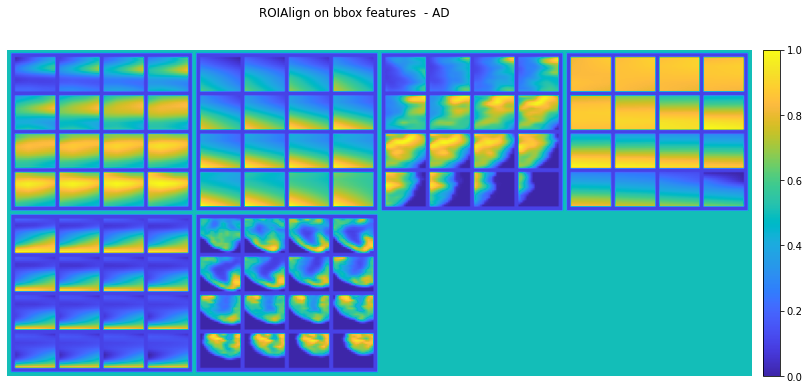

In [135]:
tmp_roialign = roi_align(TEST_IMAGES["AD"], ad_interesting, displayed=False, output_shape=cfg.ROIALIGN_SHAPE)

plt.suptitle("ROIAlign on bbox features");
imshow(
    to_grid(np.stack([to_grid(tensor2numpy(x[0]),
                              max_num_slices=16, 
                              nrow=4,
                              pad_value=0.1
                             ) for x in tmp_roialign if x.sum() != 0]), 
            pad_value=0.5,
            nrow=4
           ), 
    colormap=True, 
    figsize=(20,6)
)

plt.suptitle("ROIAlign on bbox features  - AD")

plt.savefig(f"{cfg.LOGDIR}/figures/roialign/{cfg.RUNDATE}")

<Figure size 432x288 with 0 Axes>

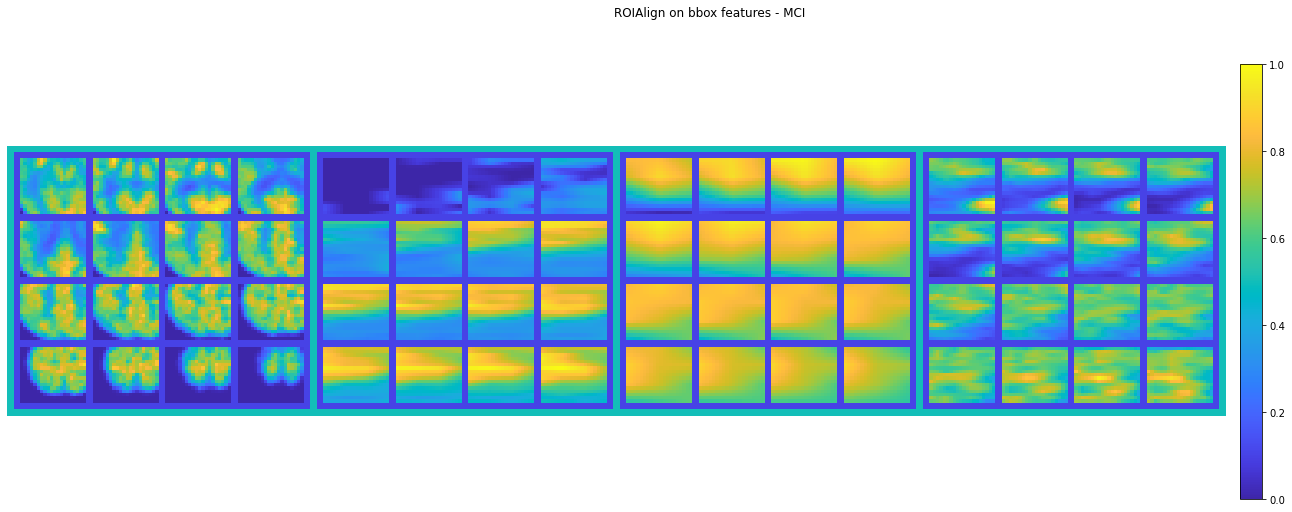

In [136]:
tmp_roialign = roi_align(TEST_IMAGES["MCI"], mci_interesting, displayed=False, output_shape=cfg.ROIALIGN_SHAPE)
#imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=16, nrow=5), colormap=True)
plt.suptitle("ROIAlign on bbox features")
imshow(
    to_grid(np.stack([to_grid(tensor2numpy(x[0]),
                              max_num_slices=16, 
                              nrow=4,pad_value=0.1
                             ) for x in tmp_roialign if x.sum() != 0]), 
            pad_value=0.5, 
            nrow=6
           ), 
    colormap=True, 
    figsize=(26,8)
)

plt.suptitle("ROIAlign on bbox features - MCI")

plt.savefig(f"{cfg.LOGDIR}/figures/roialign/{cfg.RUNDATE}")

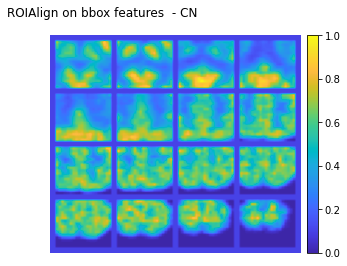

In [137]:
tmp_roialign = roi_align(TEST_IMAGES["CN"], cn_interesting, displayed=False, output_shape=cfg.ROIALIGN_SHAPE)
#imshow(to_grid(tensor2numpy(tmp_roialign[0][0]),max_num_slices=16, nrow=5), colormap=True)

imshow(
    to_grid(np.stack([to_grid(tensor2numpy(x[0]),
                              max_num_slices=16, 
                              nrow=4,pad_value=0.1
                             ) for x in tmp_roialign if x.sum() != 0]), pad_value=0.5), 
    colormap=True, 
    figsize=(10,4), 

)
plt.suptitle("ROIAlign on bbox features  - CN")


plt.savefig(f"{cfg.LOGDIR}/figures/roialign/{cfg.RUNDATE}")